In [30]:
GPU_device_id = str(6)
model_id_save_as = 'daepretrain-easy-final'
architecture_id = 'final-models/learningcurve-dnn-easy-final-features'
model_class_id = 'DAE'
training_dataset_id = '../dataset_generation/hyperparametersearch_dataset_200keV_easy_log10time_1000.npy'
difficulty_setting = 'easy'

earlystop_patience = 10
num_epochs = 2000

In [2]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_device_id


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
from random import choice

from numpy.random import seed
seed(5)
from tensorflow import set_random_seed
set_random_seed(5)



#### Import model, training function 

In [3]:
from annsa.model_classes import build_dae_model, compile_model, f1, mean_normalized_kl_divergence
from annsa.load_dataset import load_easy, load_full, dataset_to_spectrakeys
from annsa.load_pretrained_network import load_features

Using TensorFlow backend.


## Training Data Construction

In [4]:
training_dataset = np.load(training_dataset_id, allow_pickle=True)
training_source_spectra, training_background_spectra, training_keys = dataset_to_spectrakeys(training_dataset,
                                                                                             sampled=False,
                                                                                             separate_background=True)

## Load Model

In [5]:
model_features = load_features(architecture_id)
model_features.loss = tf.keras.losses.mean_squared_error
model_features.optimizer = tf.keras.optimizers.Adam
model_features.learning_rate = model_features.learining_rate
model_features.input_dim = 1024

In [6]:
dae_features = model_features.to_dae_model_features()
dae_features.metrics = ['mse']

In [7]:
model_features.scaler

Pipeline(memory=None,
     steps=[('functiontransformer', FunctionTransformer(accept_sparse=False, func=<ufunc 'sqrt'>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=True))])

## Train network

# Scale input data

In [8]:
training_input = np.random.poisson(training_source_spectra+training_background_spectra)
training_output = training_source_spectra

training_input = dae_features.scaler.transform(training_input)
training_output = dae_features.scaler.transform(training_output)


/home/ubuntu/anaconda3/envs/tensorflow_p36_update/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:161: RuntimeWarning: invalid value encountered in sqrt
  **(kw_args if kw_args else {}))


In [9]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=earlystop_patience,
    mode='min',
    restore_best_weights=True)

csv_logger = tf.keras.callbacks.CSVLogger('./final-models-keras/'+model_id_save_as+'.log')

In [10]:
mlb=LabelBinarizer()
model = compile_model(
            build_dae_model,
            dae_features)

output = model.fit(
    x=training_input,
    y=training_output,
    batch_size=model_features.batch_size,
    validation_split=0.1,
    epochs=500,
    verbose=1,
    shuffle=True,
    callbacks=[earlystop_callback, ],
)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 27000 samples, validate on 3000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
27000/27000 [==============================] - 1s 30us/sample - loss: 23.3045 - mean_squared_error: 23.3045 - val_loss: 14.8061 - val_mean_squared_error: 14.8061
Epoch 2/500
27000/27000 [==============================] - 0s 16us/sample - loss: 10.4501 - mean_squared_error: 10.4501 - val_loss: 10.2125 - val_mean_squared_error: 10.2125
Epoch 3/500
27000/27000 [==============================] - 0s 16us/sample - loss: 7.8598 - mean_squared_error: 7.8598 - val_loss: 7.4539 - val_mean_squared_error: 7.4539
Epoch 4/500
27000/27000 [==============================] - 0s 16us/sample - loss: 6.1130 - mean_squared_error: 6.1130 - val_loss: 5.8122 - val_mean_squared_error: 5.8122
Epoch 5/500
27000/27000 [===

27000/27000 [==============================] - 0s 16us/sample - loss: 2.0989 - mean_squared_error: 2.0989 - val_loss: 2.7146 - val_mean_squared_error: 2.7146
Epoch 18/500
27000/27000 [==============================] - 0s 16us/sample - loss: 2.0326 - mean_squared_error: 2.0326 - val_loss: 2.7754 - val_mean_squared_error: 2.7754
Epoch 19/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.9581 - mean_squared_error: 1.9581 - val_loss: 2.6273 - val_mean_squared_error: 2.6273
Epoch 20/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.8862 - mean_squared_error: 1.8862 - val_loss: 2.5629 - val_mean_squared_error: 2.5629
Epoch 21/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.8356 - mean_squared_error: 1.8356 - val_loss: 2.4512 - val_mean_squared_error: 2.4512
Epoch 22/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.7898 - mean_squared_error: 1.7898 - val_loss: 2.4216 - val_mean_squared_e

27000/27000 [==============================] - 0s 16us/sample - loss: 1.4894 - mean_squared_error: 1.4894 - val_loss: 2.1102 - val_mean_squared_error: 2.1102
Epoch 37/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.4680 - mean_squared_error: 1.4680 - val_loss: 2.1258 - val_mean_squared_error: 2.1258
Epoch 38/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.4756 - mean_squared_error: 1.4756 - val_loss: 2.1405 - val_mean_squared_error: 2.1405
Epoch 39/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.4623 - mean_squared_error: 1.4623 - val_loss: 2.1126 - val_mean_squared_error: 2.1126
Epoch 40/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.4385 - mean_squared_error: 1.4385 - val_loss: 2.0660 - val_mean_squared_error: 2.0660
Epoch 41/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.4367 - mean_squared_error: 1.4367 - val_loss: 2.0927 - val_mean_squared_e

27000/27000 [==============================] - 0s 16us/sample - loss: 1.3204 - mean_squared_error: 1.3204 - val_loss: 1.9966 - val_mean_squared_error: 1.9966
Epoch 56/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.3128 - mean_squared_error: 1.3128 - val_loss: 2.0299 - val_mean_squared_error: 2.0299
Epoch 57/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.2947 - mean_squared_error: 1.2947 - val_loss: 2.0531 - val_mean_squared_error: 2.0531
Epoch 58/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.2828 - mean_squared_error: 1.2828 - val_loss: 2.0085 - val_mean_squared_error: 2.0085
Epoch 59/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.3001 - mean_squared_error: 1.3001 - val_loss: 2.0039 - val_mean_squared_error: 2.0039
Epoch 60/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.2834 - mean_squared_error: 1.2834 - val_loss: 2.0742 - val_mean_squared_e

27000/27000 [==============================] - 0s 16us/sample - loss: 1.1997 - mean_squared_error: 1.1997 - val_loss: 2.0556 - val_mean_squared_error: 2.0556
Epoch 75/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.1772 - mean_squared_error: 1.1772 - val_loss: 2.0603 - val_mean_squared_error: 2.0603
Epoch 76/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.1804 - mean_squared_error: 1.1804 - val_loss: 2.0743 - val_mean_squared_error: 2.0743
Epoch 77/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.1720 - mean_squared_error: 1.1720 - val_loss: 1.9942 - val_mean_squared_error: 1.9942
Epoch 78/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.1754 - mean_squared_error: 1.1754 - val_loss: 1.9968 - val_mean_squared_error: 1.9968
Epoch 79/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.1598 - mean_squared_error: 1.1598 - val_loss: 2.0387 - val_mean_squared_e

27000/27000 [==============================] - 0s 16us/sample - loss: 1.0854 - mean_squared_error: 1.0854 - val_loss: 2.0029 - val_mean_squared_error: 2.0029
Epoch 94/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0698 - mean_squared_error: 1.0698 - val_loss: 2.0171 - val_mean_squared_error: 2.0171
Epoch 95/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0764 - mean_squared_error: 1.0764 - val_loss: 2.0564 - val_mean_squared_error: 2.0564
Epoch 96/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0716 - mean_squared_error: 1.0716 - val_loss: 1.9754 - val_mean_squared_error: 1.9754
Epoch 97/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0628 - mean_squared_error: 1.0628 - val_loss: 2.0327 - val_mean_squared_error: 2.0327
Epoch 98/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0668 - mean_squared_error: 1.0668 - val_loss: 2.0332 - val_mean_squared_e

27000/27000 [==============================] - 0s 16us/sample - loss: 1.0278 - mean_squared_error: 1.0278 - val_loss: 2.0156 - val_mean_squared_error: 2.0156
Epoch 113/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0219 - mean_squared_error: 1.0219 - val_loss: 2.0292 - val_mean_squared_error: 2.0292
Epoch 114/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0196 - mean_squared_error: 1.0196 - val_loss: 2.0244 - val_mean_squared_error: 2.0244
Epoch 115/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0213 - mean_squared_error: 1.0213 - val_loss: 2.0316 - val_mean_squared_error: 2.0316
Epoch 116/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0220 - mean_squared_error: 1.0220 - val_loss: 2.0161 - val_mean_squared_error: 2.0161
Epoch 117/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0297 - mean_squared_error: 1.0297 - val_loss: 2.0710 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 1.0032 - mean_squared_error: 1.0032 - val_loss: 2.0217 - val_mean_squared_error: 2.0217
Epoch 132/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0023 - mean_squared_error: 1.0023 - val_loss: 2.0351 - val_mean_squared_error: 2.0351
Epoch 133/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9916 - mean_squared_error: 0.9916 - val_loss: 2.0185 - val_mean_squared_error: 2.0185
Epoch 134/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9922 - mean_squared_error: 0.9922 - val_loss: 2.0202 - val_mean_squared_error: 2.0202
Epoch 135/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9920 - mean_squared_error: 0.9920 - val_loss: 2.0460 - val_mean_squared_error: 2.0460
Epoch 136/500
27000/27000 [==============================] - 0s 16us/sample - loss: 1.0046 - mean_squared_error: 1.0046 - val_loss: 2.0431 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.9944 - mean_squared_error: 0.9944 - val_loss: 2.0590 - val_mean_squared_error: 2.0590
Epoch 151/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9818 - mean_squared_error: 0.9818 - val_loss: 2.0331 - val_mean_squared_error: 2.0331
Epoch 152/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9782 - mean_squared_error: 0.9782 - val_loss: 2.0352 - val_mean_squared_error: 2.0352
Epoch 153/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9831 - mean_squared_error: 0.9831 - val_loss: 2.0998 - val_mean_squared_error: 2.0998
Epoch 154/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9833 - mean_squared_error: 0.9833 - val_loss: 2.0581 - val_mean_squared_error: 2.0581
Epoch 155/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9811 - mean_squared_error: 0.9811 - val_loss: 2.0602 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.9851 - mean_squared_error: 0.9851 - val_loss: 2.0865 - val_mean_squared_error: 2.0865
Epoch 170/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9571 - mean_squared_error: 0.9571 - val_loss: 2.0958 - val_mean_squared_error: 2.0958
Epoch 171/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9635 - mean_squared_error: 0.9635 - val_loss: 2.0433 - val_mean_squared_error: 2.0433
Epoch 172/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9648 - mean_squared_error: 0.9648 - val_loss: 2.0947 - val_mean_squared_error: 2.0947
Epoch 173/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9761 - mean_squared_error: 0.9761 - val_loss: 2.2544 - val_mean_squared_error: 2.2544
Epoch 174/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9901 - mean_squared_error: 0.9901 - val_loss: 2.1177 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.9507 - mean_squared_error: 0.9507 - val_loss: 2.0600 - val_mean_squared_error: 2.0600
Epoch 189/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9555 - mean_squared_error: 0.9555 - val_loss: 2.0890 - val_mean_squared_error: 2.0890
Epoch 190/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9572 - mean_squared_error: 0.9572 - val_loss: 2.0708 - val_mean_squared_error: 2.0708
Epoch 191/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9439 - mean_squared_error: 0.9439 - val_loss: 2.0705 - val_mean_squared_error: 2.0705
Epoch 192/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9504 - mean_squared_error: 0.9504 - val_loss: 2.0644 - val_mean_squared_error: 2.0644
Epoch 193/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9607 - mean_squared_error: 0.9607 - val_loss: 2.0800 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.9493 - mean_squared_error: 0.9493 - val_loss: 2.1306 - val_mean_squared_error: 2.1306
Epoch 208/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9523 - mean_squared_error: 0.9523 - val_loss: 2.0580 - val_mean_squared_error: 2.0580
Epoch 209/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9430 - mean_squared_error: 0.9430 - val_loss: 2.0861 - val_mean_squared_error: 2.0861
Epoch 210/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9462 - mean_squared_error: 0.9462 - val_loss: 2.0837 - val_mean_squared_error: 2.0837
Epoch 211/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9425 - mean_squared_error: 0.9425 - val_loss: 2.1406 - val_mean_squared_error: 2.1406
Epoch 212/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9490 - mean_squared_error: 0.9490 - val_loss: 2.1006 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.9398 - mean_squared_error: 0.9398 - val_loss: 2.0999 - val_mean_squared_error: 2.0999
Epoch 227/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9340 - mean_squared_error: 0.9340 - val_loss: 2.0927 - val_mean_squared_error: 2.0927
Epoch 228/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9343 - mean_squared_error: 0.9343 - val_loss: 2.0597 - val_mean_squared_error: 2.0597
Epoch 229/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9531 - mean_squared_error: 0.9531 - val_loss: 2.1083 - val_mean_squared_error: 2.1083
Epoch 230/500
27000/27000 [==============================] - 0s 17us/sample - loss: 0.9343 - mean_squared_error: 0.9343 - val_loss: 2.1071 - val_mean_squared_error: 2.1071
Epoch 231/500
27000/27000 [==============================] - 0s 17us/sample - loss: 0.9420 - mean_squared_error: 0.9420 - val_loss: 2.1517 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.9290 - mean_squared_error: 0.9290 - val_loss: 2.1045 - val_mean_squared_error: 2.1045
Epoch 246/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9340 - mean_squared_error: 0.9340 - val_loss: 2.1192 - val_mean_squared_error: 2.1192
Epoch 247/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9378 - mean_squared_error: 0.9378 - val_loss: 2.0986 - val_mean_squared_error: 2.0986
Epoch 248/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9436 - mean_squared_error: 0.9436 - val_loss: 2.1341 - val_mean_squared_error: 2.1341
Epoch 249/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9330 - mean_squared_error: 0.9330 - val_loss: 2.1235 - val_mean_squared_error: 2.1235
Epoch 250/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9394 - mean_squared_error: 0.9394 - val_loss: 2.1173 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.9321 - mean_squared_error: 0.9321 - val_loss: 2.2224 - val_mean_squared_error: 2.2224
Epoch 265/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9381 - mean_squared_error: 0.9381 - val_loss: 2.1049 - val_mean_squared_error: 2.1049
Epoch 266/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9210 - mean_squared_error: 0.9210 - val_loss: 2.1498 - val_mean_squared_error: 2.1498
Epoch 267/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9209 - mean_squared_error: 0.9209 - val_loss: 2.1580 - val_mean_squared_error: 2.1580
Epoch 268/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9185 - mean_squared_error: 0.9185 - val_loss: 2.1147 - val_mean_squared_error: 2.1147
Epoch 269/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9340 - mean_squared_error: 0.9340 - val_loss: 2.1287 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.9213 - mean_squared_error: 0.9213 - val_loss: 2.1288 - val_mean_squared_error: 2.1288
Epoch 284/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9278 - mean_squared_error: 0.9278 - val_loss: 2.1815 - val_mean_squared_error: 2.1815
Epoch 285/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9407 - mean_squared_error: 0.9407 - val_loss: 2.1433 - val_mean_squared_error: 2.1433
Epoch 286/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9308 - mean_squared_error: 0.9308 - val_loss: 2.1629 - val_mean_squared_error: 2.1629
Epoch 287/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9133 - mean_squared_error: 0.9133 - val_loss: 2.1298 - val_mean_squared_error: 2.1298
Epoch 288/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9271 - mean_squared_error: 0.9271 - val_loss: 2.1171 - val_mean_squa

27000/27000 [==============================] - 0s 17us/sample - loss: 0.9127 - mean_squared_error: 0.9127 - val_loss: 2.1174 - val_mean_squared_error: 2.1174
Epoch 303/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9147 - mean_squared_error: 0.9147 - val_loss: 2.2048 - val_mean_squared_error: 2.2048
Epoch 304/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9173 - mean_squared_error: 0.9173 - val_loss: 2.1549 - val_mean_squared_error: 2.1549
Epoch 305/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9179 - mean_squared_error: 0.9179 - val_loss: 2.1282 - val_mean_squared_error: 2.1282
Epoch 306/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9325 - mean_squared_error: 0.9325 - val_loss: 2.1764 - val_mean_squared_error: 2.1764
Epoch 307/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9198 - mean_squared_error: 0.9198 - val_loss: 2.1400 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.9111 - mean_squared_error: 0.9111 - val_loss: 2.1239 - val_mean_squared_error: 2.1239
Epoch 322/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9187 - mean_squared_error: 0.9187 - val_loss: 2.1479 - val_mean_squared_error: 2.1479
Epoch 323/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9084 - mean_squared_error: 0.9084 - val_loss: 2.1197 - val_mean_squared_error: 2.1197
Epoch 324/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9077 - mean_squared_error: 0.9077 - val_loss: 2.1752 - val_mean_squared_error: 2.1752
Epoch 325/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9142 - mean_squared_error: 0.9142 - val_loss: 2.1836 - val_mean_squared_error: 2.1836
Epoch 326/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9143 - mean_squared_error: 0.9143 - val_loss: 2.1101 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.9155 - mean_squared_error: 0.9155 - val_loss: 2.1386 - val_mean_squared_error: 2.1386
Epoch 341/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9094 - mean_squared_error: 0.9094 - val_loss: 2.1425 - val_mean_squared_error: 2.1425
Epoch 342/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9113 - mean_squared_error: 0.9113 - val_loss: 2.1564 - val_mean_squared_error: 2.1564
Epoch 343/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9152 - mean_squared_error: 0.9152 - val_loss: 2.1370 - val_mean_squared_error: 2.1370
Epoch 344/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9082 - mean_squared_error: 0.9082 - val_loss: 2.1470 - val_mean_squared_error: 2.1470
Epoch 345/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9051 - mean_squared_error: 0.9051 - val_loss: 2.1361 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.8996 - mean_squared_error: 0.8996 - val_loss: 2.1273 - val_mean_squared_error: 2.1273
Epoch 360/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9006 - mean_squared_error: 0.9006 - val_loss: 2.1444 - val_mean_squared_error: 2.1444
Epoch 361/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8983 - mean_squared_error: 0.8983 - val_loss: 2.1620 - val_mean_squared_error: 2.1620
Epoch 362/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9191 - mean_squared_error: 0.9191 - val_loss: 2.1512 - val_mean_squared_error: 2.1512
Epoch 363/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9221 - mean_squared_error: 0.9221 - val_loss: 2.1299 - val_mean_squared_error: 2.1299
Epoch 364/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9060 - mean_squared_error: 0.9060 - val_loss: 2.1797 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.8989 - mean_squared_error: 0.8989 - val_loss: 2.1392 - val_mean_squared_error: 2.1392
Epoch 379/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9098 - mean_squared_error: 0.9098 - val_loss: 2.1505 - val_mean_squared_error: 2.1505
Epoch 380/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9023 - mean_squared_error: 0.9023 - val_loss: 2.1589 - val_mean_squared_error: 2.1589
Epoch 381/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8947 - mean_squared_error: 0.8947 - val_loss: 2.2104 - val_mean_squared_error: 2.2104
Epoch 382/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9018 - mean_squared_error: 0.9018 - val_loss: 2.1768 - val_mean_squared_error: 2.1768
Epoch 383/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9044 - mean_squared_error: 0.9044 - val_loss: 2.2822 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.8926 - mean_squared_error: 0.8926 - val_loss: 2.1660 - val_mean_squared_error: 2.1660
Epoch 398/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8902 - mean_squared_error: 0.8902 - val_loss: 2.1164 - val_mean_squared_error: 2.1164
Epoch 399/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8984 - mean_squared_error: 0.8984 - val_loss: 2.1723 - val_mean_squared_error: 2.1723
Epoch 400/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8969 - mean_squared_error: 0.8969 - val_loss: 2.1473 - val_mean_squared_error: 2.1473
Epoch 401/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8952 - mean_squared_error: 0.8952 - val_loss: 2.1593 - val_mean_squared_error: 2.1593
Epoch 402/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8905 - mean_squared_error: 0.8905 - val_loss: 2.1437 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.8949 - mean_squared_error: 0.8949 - val_loss: 2.1816 - val_mean_squared_error: 2.1816
Epoch 417/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8888 - mean_squared_error: 0.8888 - val_loss: 2.2241 - val_mean_squared_error: 2.2241
Epoch 418/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8904 - mean_squared_error: 0.8904 - val_loss: 2.1524 - val_mean_squared_error: 2.1524
Epoch 419/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9017 - mean_squared_error: 0.9017 - val_loss: 2.1821 - val_mean_squared_error: 2.1821
Epoch 420/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8900 - mean_squared_error: 0.8900 - val_loss: 2.1762 - val_mean_squared_error: 2.1762
Epoch 421/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8953 - mean_squared_error: 0.8953 - val_loss: 2.1629 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.8898 - mean_squared_error: 0.8898 - val_loss: 2.1559 - val_mean_squared_error: 2.1559
Epoch 436/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8894 - mean_squared_error: 0.8894 - val_loss: 2.1729 - val_mean_squared_error: 2.1729
Epoch 437/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8861 - mean_squared_error: 0.8861 - val_loss: 2.1802 - val_mean_squared_error: 2.1802
Epoch 438/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8879 - mean_squared_error: 0.8879 - val_loss: 2.1778 - val_mean_squared_error: 2.1778
Epoch 439/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8924 - mean_squared_error: 0.8924 - val_loss: 2.1704 - val_mean_squared_error: 2.1704
Epoch 440/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8852 - mean_squared_error: 0.8852 - val_loss: 2.1318 - val_mean_squa

27000/27000 [==============================] - 0s 17us/sample - loss: 0.8821 - mean_squared_error: 0.8821 - val_loss: 2.2025 - val_mean_squared_error: 2.2025
Epoch 455/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8791 - mean_squared_error: 0.8791 - val_loss: 2.2043 - val_mean_squared_error: 2.2043
Epoch 456/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8807 - mean_squared_error: 0.8807 - val_loss: 2.1377 - val_mean_squared_error: 2.1377
Epoch 457/500
27000/27000 [==============================] - 0s 17us/sample - loss: 0.8903 - mean_squared_error: 0.8903 - val_loss: 2.1441 - val_mean_squared_error: 2.1441
Epoch 458/500
27000/27000 [==============================] - 0s 17us/sample - loss: 0.8855 - mean_squared_error: 0.8855 - val_loss: 2.2081 - val_mean_squared_error: 2.2081
Epoch 459/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.9034 - mean_squared_error: 0.9034 - val_loss: 2.1759 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.8826 - mean_squared_error: 0.8826 - val_loss: 2.1530 - val_mean_squared_error: 2.1530
Epoch 474/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8710 - mean_squared_error: 0.8710 - val_loss: 2.1670 - val_mean_squared_error: 2.1670
Epoch 475/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8812 - mean_squared_error: 0.8812 - val_loss: 2.1798 - val_mean_squared_error: 2.1798
Epoch 476/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8746 - mean_squared_error: 0.8746 - val_loss: 2.1831 - val_mean_squared_error: 2.1831
Epoch 477/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8732 - mean_squared_error: 0.8732 - val_loss: 2.1511 - val_mean_squared_error: 2.1511
Epoch 478/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8796 - mean_squared_error: 0.8796 - val_loss: 2.1619 - val_mean_squa

27000/27000 [==============================] - 0s 16us/sample - loss: 0.8706 - mean_squared_error: 0.8706 - val_loss: 2.1555 - val_mean_squared_error: 2.1555
Epoch 493/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8784 - mean_squared_error: 0.8784 - val_loss: 2.1989 - val_mean_squared_error: 2.1989
Epoch 494/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8699 - mean_squared_error: 0.8699 - val_loss: 2.1401 - val_mean_squared_error: 2.1401
Epoch 495/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8706 - mean_squared_error: 0.8706 - val_loss: 2.1502 - val_mean_squared_error: 2.1502
Epoch 496/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8822 - mean_squared_error: 0.8822 - val_loss: 2.1380 - val_mean_squared_error: 2.1380
Epoch 497/500
27000/27000 [==============================] - 0s 16us/sample - loss: 0.8827 - mean_squared_error: 0.8827 - val_loss: 2.1482 - val_mean_squa

In [31]:
model.save('./final-models-keras/'+model_id_save_as+'.hdf5')

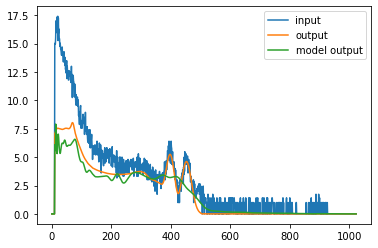

In [26]:
index = 1007

plt.plot(training_input[index:index+1][0], label='input')
plt.plot(training_output[index:index+1][0], label='output')
plt.plot(model.predict(training_input[index:index+1])[0], label='model output')
plt.legend()